## 1. Get-Started

In [6]:
from IPython.display import Image, clear_output  # to display images

In [7]:
# import required dependencies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm.auto import tqdm
import shutil as sh

import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
# read the training data.

df = pd.read_csv('./global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0
from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]

In [9]:
df.head()

,image_id,x,y,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,862.0,240.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,291.0,577.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,414.0,584.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,888.5,148.5,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,88.0,202.5,0


In [10]:
index = list(set(df.image_id))
len(index)

3373

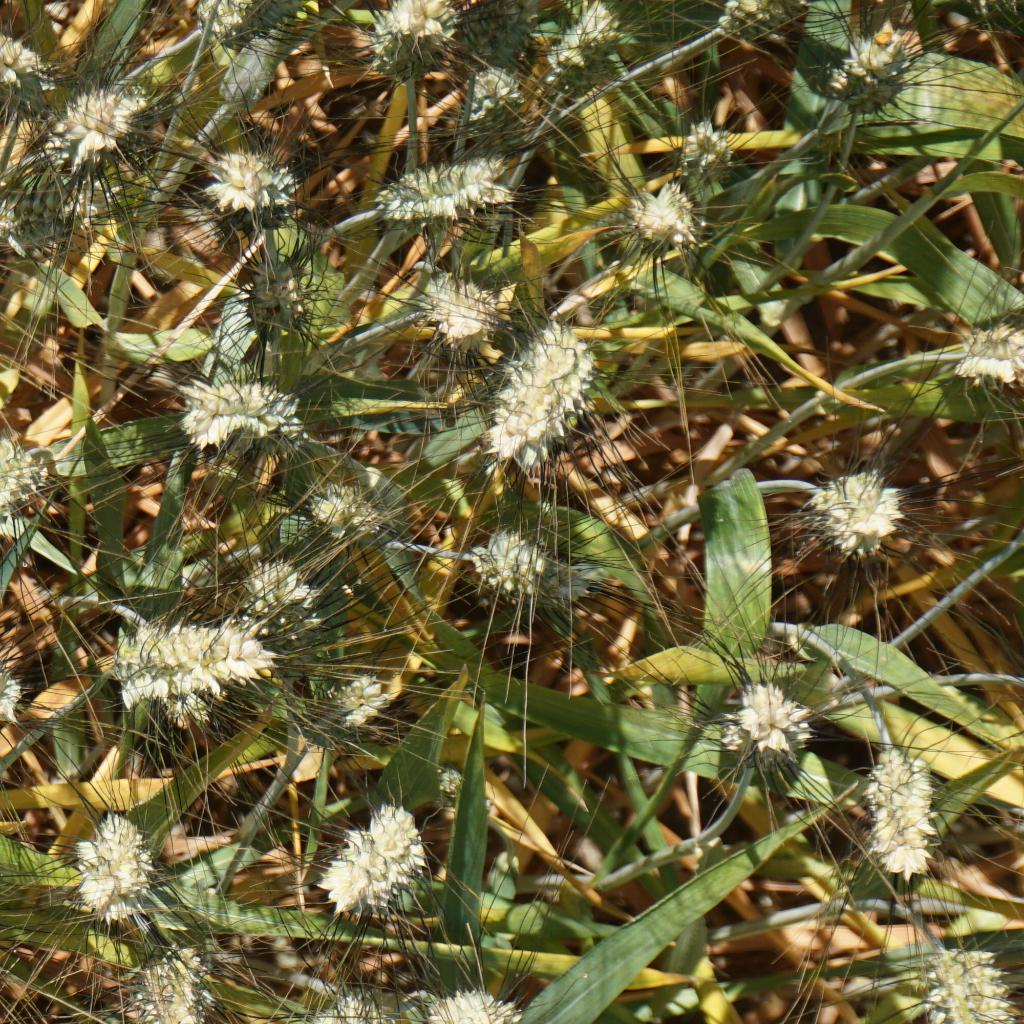

In [11]:
Image(filename='./global-wheat-detection/train/b902a5132.jpg',width=600)

## 2. Pre-Processing

In [1]:
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
import shutil as sh
from sklearn.model_selection import StratifiedKFold

SEED = 42

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

In [2]:
marking = pd.read_csv('./global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
marking['area'] = marking['w'] * marking['h']
marking=marking[marking['area']<100000].reset_index(drop=True)
del marking['area']
#marking.head()

In [3]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

#df_folds.head()

/home2/rh/anaconda3/envs/yolov5/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


In [4]:
folds=df_folds.reset_index()
index=list(set(folds.image_id))

fold=0
val_fold=folds[folds['fold']==fold]
val_index=list(set(val_fold.image_id))

print(f'Train size: {len(index)-len(val_index)} \nVal size: {len(val_index)}')

Train size: 3035 
Val size: 338


In [5]:
df = pd.read_csv('./global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0
df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]
df['area'] = df['w'] * df['h']
df=df[df['area']<100000].reset_index(drop=True)
del df['area']
#df.head()

In [ ]:
source = 'train'

fold=0    #Always 0 for the pipeline to work
for name,mini in tqdm(df.groupby('image_id')):
    if name in val_index:
        path2save = 'val2017/'
    else:
        path2save = 'train2017/'
    if not os.path.exists('./convertor/fold{}/labels/'.format(fold)+path2save):
        os.makedirs('./convertor/fold{}/labels/'.format(fold)+path2save)
    with open('./convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
        row = mini[['classes','x_center','y_center','w','h']].astype(float).values
        row = row/1024
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")
    if not os.path.exists('./convertor/fold{}/images/{}'.format(fold,path2save)):
        os.makedirs('./convertor/fold{}/images/{}'.format(fold,path2save))
    sh.copy("./global-wheat-detection/{}/{}.jpg".format(source,name),'./convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))